In [1]:
import os
import shutil
import random

# Paths
data_dir = "processed_data_resized"  # Folder containing images
output_dir = "dataset_split"  # Folder for train/val/test split
os.makedirs(output_dir, exist_ok=True)

# Split Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Categories (Nodule & Non-Nodule)
categories = ["nodules", "non_nodules"]


# Function to split dataset
def split_data():
    for category in categories:
        category_path = os.path.join(data_dir, category)
        files = os.listdir(category_path)
        random.shuffle(files)

        train_split = int(len(files) * train_ratio)
        val_split = train_split + int(len(files) * val_ratio)

        subsets = {
            "train": files[:train_split],
            "val": files[train_split:val_split],
            "test": files[val_split:],
        }

        for subset, subset_files in subsets.items():
            subset_dir = os.path.join(output_dir, subset, category)
            os.makedirs(subset_dir, exist_ok=True)

            for file in subset_files:
                src = os.path.join(category_path, file)
                dst = os.path.join(subset_dir, file)
                shutil.copy(src, dst)

    print("✅ Dataset splitting completed!")


split_data()

✅ Dataset splitting completed!


In [2]:
for subset in ["train", "val", "test"]:
    print(f"📂 Checking {subset} set:")
    for category in categories:
        path = os.path.join(output_dir, subset, category)
        print(f"  {category}: {len(os.listdir(path))} images")

📂 Checking train set:
  nodules: 308 images
  non_nodules: 16 images
📂 Checking val set:
  nodules: 66 images
  non_nodules: 3 images
📂 Checking test set:
  nodules: 66 images
  non_nodules: 4 images


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Data transformations
transform = transforms.Compose(
    [
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load datasets
data_dir = "dataset_split"

train_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "train"), transform=transform
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "val"), transform=transform
)
test_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "test"), transform=transform
)

# Class counts for weighting
class_counts = np.bincount([label for _, label in train_dataset])
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

# Print class weights
print(
    f"✅ Class weights: Nodule = {class_weights[1]:.4f}, Non-Nodule = {class_weights[0]:.4f}"
)

# Create DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("✅ DataLoader created successfully!")

c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


✅ Class weights: Nodule = 0.0625, Non-Nodule = 0.0032
✅ DataLoader created successfully!


In [4]:
import timm
import torch.nn as nn

# Load EfficientNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=2)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("✅ Model initialized!")

c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Model initialized!


c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\emada\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}"
        )

    print("✅ Training complete!")


train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10, Loss: 1.8187, Accuracy: 0.6883
Epoch 2/10, Loss: 0.4737, Accuracy: 0.7901
Epoch 3/10, Loss: 0.0417, Accuracy: 0.9846
Epoch 4/10, Loss: 0.0127, Accuracy: 0.9938
Epoch 5/10, Loss: 0.0141, Accuracy: 0.9938
Epoch 6/10, Loss: 0.0212, Accuracy: 1.0000
Epoch 7/10, Loss: 0.0132, Accuracy: 0.9969
Epoch 8/10, Loss: 0.0084, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0111, Accuracy: 0.9969
Epoch 10/10, Loss: 0.0167, Accuracy: 0.9969
✅ Training complete!


✅ Validation ROC-AUC Score: 0.6869

📊 Validation Classification Report:

              precision    recall  f1-score   support

  Non-Nodule       0.95      0.94      0.95        66
      Nodule       0.00      0.00      0.00         3

    accuracy                           0.90        69
   macro avg       0.48      0.47      0.47        69
weighted avg       0.91      0.90      0.91        69



C:\Users\emada\AppData\Local\Temp\ipykernel_16016\240115053.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", lw=1, linestyle="--")  # Diagonal line


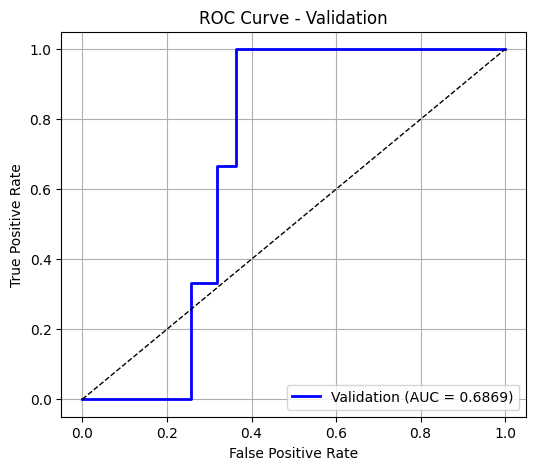

✅ Test ROC-AUC Score: 0.7121

📊 Test Classification Report:

              precision    recall  f1-score   support

  Non-Nodule       0.94      0.98      0.96        66
      Nodule       0.00      0.00      0.00         4

    accuracy                           0.93        70
   macro avg       0.47      0.49      0.48        70
weighted avg       0.89      0.93      0.91        70



C:\Users\emada\AppData\Local\Temp\ipykernel_16016\240115053.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", lw=1, linestyle="--")  # Diagonal line


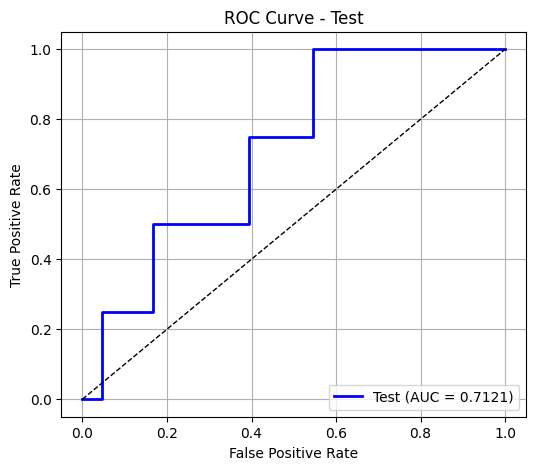

In [6]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np


# Function to evaluate model performance
def evaluate_model(model, loader, dataset_type):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get softmax probabilities for the positive class (nodule)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs)

    # Compute ROC-AUC Score
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"✅ {dataset_type} ROC-AUC Score: {roc_auc:.4f}")

    # Generate Classification Report
    y_pred_labels = [1 if p > 0.5 else 0 for p in y_pred]
    print(f"\n📊 {dataset_type} Classification Report:\n")
    print(
        classification_report(
            y_true, y_pred_labels, target_names=["Non-Nodule", "Nodule"]
        )
    )

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    # Plot ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(
        fpr, tpr, label=f"{dataset_type} (AUC = {roc_auc:.4f})", color="blue", lw=2
    )
    plt.plot([0, 1], [0, 1], "k--", lw=1, linestyle="--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_type}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Evaluate on validation and test sets
evaluate_model(model, val_loader, "Validation")
evaluate_model(model, test_loader, "Test")